# MLCV Assignment: Semantic Segmentation of Unexpected Objects on Roads

*   **Student ID:** 0001111416
*   **Full Name:** Alessio Pittiglio
*   **Institutional Email:** alessio.pittiglio@studio.unibo.it

## 1. Introduction

This project addresses the task of **semantic segmentation of unexpected objects on roads**, more generally known in the literature as *open-set semantic segmentation*, *open-world semantic segmentation*, or *anomaly segmentation*.

Traditional semantic segmentation methods often fail to detect objects that were not seen during training (e.g., a cat on the road misclassified as asphalt). This limitation poses significant challenges for safety-critical applications such as autonomous driving.

The goal of this project is to develop and evaluate a model capable of segmenting 12 known classes from the StreetHazards dataset (`building`, `fence`, `other`, `pedestrian`, `pole`, `road line`, `road`, `sidewalk`, `vegetation`, `car`, `wall`, `traffic sign`) and additionally identifying anomalous objects that appear only in the test set.

This notebook will guide you through the setup, data loading, model definition, evaluation, and qualitative analysis of the results. We use PyTorch Lightning for structuring the code and Weights & Biases for experiment tracking.

## 2. Setup and Configuration

First, we import the necessary libraries and set the random seeds for reproducibility. We also import the custom modules implemented for this project (`datamodule.py`, `model_uncertainty.py`, `model_metric.py`, etc.).

In [1]:
import torch
import matplotlib.pyplot as plt
import lightning as L

from pathlib import Path

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.transforms import v2

from mlcv_openset_segmentation.datamodule import StreetHazardsDataModule
from mlcv_openset_segmentation.model_uncertainty import UncertaintyModel
from mlcv_openset_segmentation.model_metric import MetricLearningModel

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
L.seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


We define hyperparameters used for data loading, the model architecture, as well as those for storing the path to the trained model checkpoint.

In [4]:
DATA_DIR = Path("data/")
BATCH_SIZE = 8
NUM_WORKERS = 4
IMG_HEIGHT = 512
IMG_WIDTH = 1024
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
CHECKPOINT_PATH = "checkpoints/z5wqvtgk/epoch=08-val_miou=0.61.ckpt"

We configure Weights & Biases for logging. Make sure you are logged in via the command line (`wandb login`) before running any W&B-related code or viewing runs.

In [5]:
import wandb

## 3. Data Loading and Preparation

We utilize a `StreetHazardsDataModule` built with PyTorch Lightning to handle the loading and preparation of the StreetHazards dataset. This module encapsulates the `StreetHazardsDataset` class, which parses the `.odgt` files and constructs `DataLoader` instances for training, validation, and test sets. Appropriate transforms (resizing, normalization, tensor conversion) are applied during preprocessing. During training, we include `RandomHorizontalFlip` as a data augmentation to improve generalization. Across all splits, images are normalized using the ImageNet mean and standard deviation, since the model's backbone is pre-trained on this dataset.

In [6]:
train_transform = v2.Compose(
    [
        v2.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=v2.InterpolationMode.BILINEAR),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD),
    ]
)

eval_transform = v2.Compose(
    [
        v2.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=v2.InterpolationMode.BILINEAR),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD),
    ]
)

In [7]:
data_module = StreetHazardsDataModule(
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transform=train_transform,
    eval_transform=eval_transform,
)

data_module.prepare_data()
data_module.setup()

Let's visualize an example from the test set along with its corresponding ground-truth segmentation mask.

In [8]:
mean = torch.tensor(IMG_MEAN).view(3, 1, 1)
std = torch.tensor(IMG_STD).view(3, 1, 1)

In [9]:
def unnormalize(img):
    return img * std + mean

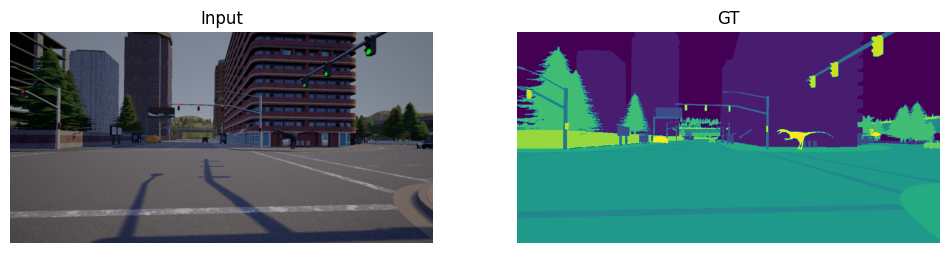

In [10]:
test_loader = data_module.test_dataloader()
batch = next(iter(test_loader))
image, mask_target = batch

image = unnormalize(image)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[3].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask_target[3])
plt.title("GT")
plt.axis("off")
plt.show()

One important consideration concerns the classes `unlabeled` and `other`. A visual analysis shows that `unlabeled` is used to represent the background, which mostly corresponds to the sky. However, there are instances where other elements (such as bridges or elevated railways) are included in the background. The class `other` also appears to represent several different objects. Therefore, this may introduce ambiguity and misclassifications that can affect the final results.